# Project Proposal: Predicting User Knowledge from Study Habits and Exam Performance


## Introduction: Data set and background information

### About the data set

**Our data set: User Knowledge Modeling (https://doi.org/10.24432/C5231X)** [2]

We have chosen to explore the user User Knowledge Modeling data set (Kahraman, Colak, & Sagiroglu, 2013), which is a data set that classifies users' knowledge of a topic (Electrical DC machines) according to a number of features.

A) Goal topics (learning objects):
1. The degree of time spent studying the material [STG]
2. The degree of repetition of the material [SCG]
3. The performance in exams [PEG]

B) Prerequisite topics
1. The degree of study time corresponding to the prerequisite objects [STR]
2. The knowledge level of the prerequisite objects [LPR]

The goal is to predict user knowledge [UNS].

UNS has four levels: very low, low, middle, high. In order, this corresponds to the user's knowledge beginner, intermediate, expert, advanced (Kahraman, Colak, & Sagiroglu, 2013).

### Background Information

#### User Knowledge

User knowledge can be used to evaluate and dynamically shape the learning experience of an individual, especially when it applies to an online learning environment (Kahraman, Colak, & Sagiroglu, 2013). The data set we are using examines different features of a user's learning experience to evaluate their knowledge level.

### Our Question

The question we are trying to answer is:

**Can we predict the knowledge level of a user given the time they spent studying and their performance on the exam?**

## Preliminary exploratory data analysis

### Loading necessary libraries and reading in the data

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
library(kknn)
install.packages("RColorBrewer")
library(RColorBrewer)

dc_machines <- read_csv("https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

### Make data more readbable

In [2]:
dc_machines_mutate <- dc_machines |>
    mutate(UNS = as_factor(UNS)) |>
    rename("study_time_goal" = STG, 
           "repitition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS)
glimpse(dc_machines_mutate)

Rows: 258
Columns: 6
$ study_time_goal     <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.09, 0.10, 0.15, 0.…
$ repitition          <dbl> 0.00, 0.08, 0.06, 0.10, 0.08, 0.15, 0.10, 0.02, 0.…
$ study_time_related  <dbl> 0.00, 0.10, 0.05, 0.15, 0.08, 0.40, 0.43, 0.34, 0.…
$ performance_related <dbl> 0.00, 0.24, 0.25, 0.65, 0.98, 0.10, 0.29, 0.40, 0.…
$ performance_goal    <dbl> 0.00, 0.90, 0.33, 0.30, 0.24, 0.66, 0.56, 0.01, 0.…
$ user_knowledge      <fct> very_low, High, Low, Middle, Low, Middle, Middle, …


### Set seed in order to make data reproducible

In [3]:
set.seed(200)

### Split the data into training and testing sets

We decided to use a proportion of 0.75 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [4]:
dc_machines_split <- initial_split(dc_machines_mutate, prop = 0.75, strata = user_knowledge)
dc_machines_training <- training(dc_machines_split)
dc_machines_testing <- testing(dc_machines_split)

### Summarizing the data

We first wanted to see how balanced-unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable. 

We can see that the very_low (beginner) knowledge level is not as represented in this dataset.

In [5]:
summary_counts <- dc_machines_training |>
    group_by(user_knowledge) |>
    summarize(count = n())
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


We then wanted to look at the means of our predictors for each class.

In [6]:
summary <- dc_machines_training |>
    select(user_knowledge, study_time_goal, performance_goal) |>
    group_by(user_knowledge) |>
    summarize("mean_study_time" = mean(study_time_goal), "mean_exam_score" = mean(performance_goal))
summary

user_knowledge,mean_study_time,mean_exam_score
<fct>,<dbl>,<dbl>
very_low,0.3172000,0.0985000
High,0.4220000,0.7646809
Low,0.3249831,0.2386949
Middle,0.4147727,0.5430303


### Visualize the data

We first wanted to visualize the distribution of the different groups. Again, this highlights that the data is not completely balanced.

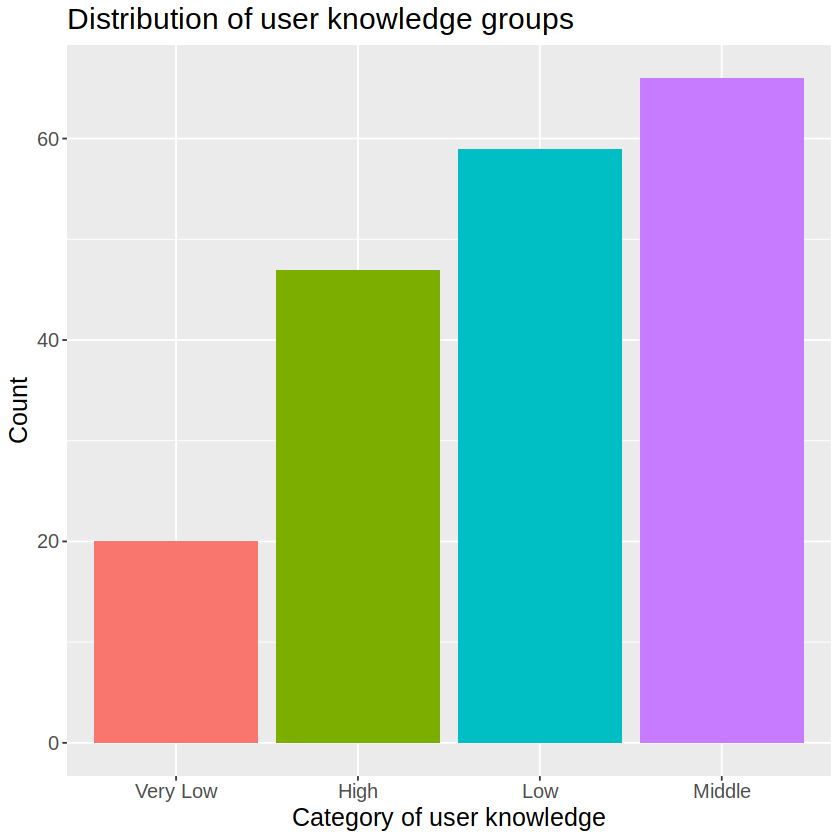

In [7]:
dc_machines_plot_distribution <- dc_machines_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) +
    geom_bar() +
    xlab("Category of user knowledge") +
    ylab("Count") +
    theme(text = element_text(size = 15), legend.position = "none") +
    ggtitle("Distribution of user knowledge groups") +
    scale_color_brewer(palette = "Set2")
    
dc_machines_plot_distribution

Then, we plotted the data according to study time and exam performance of each of the user knowledge groups. We start to see some distinct groups form.

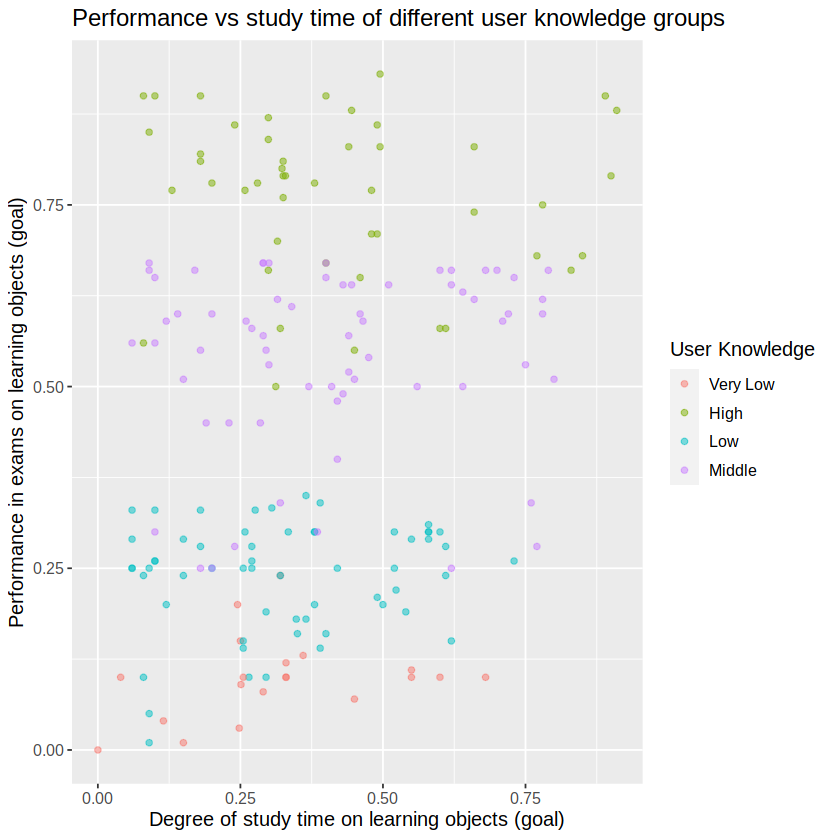

In [8]:
dc_machines_plot_study_vs_goal <- dc_machines_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, color = fct_recode(user_knowledge, "Very Low" = "very_low"))) +
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance in exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 12)) +
    ggtitle("Performance vs study time of different user knowledge groups")
dc_machines_plot_study_vs_goal

## Methods

### Classification System

K-Nearest Neighbors (KNN) is a classification method that predicts the classification of new, unlabeled observations based on the classes of its closest neighbors. KNN uses the distance between two points (Euclidean distance) in order to determine the proximity to each point to the new observation, then conducts of vote using the the chosen number of neighbors (K). Each nearby neighbour gets one vote (rectangular weight function), and the unlabeled observation is given the classification according to whichever class contributes the greatest number of votes. 

We will be using KNN in our project to determine if the user knowledge level of individual can be predicted using their study habits and exam performance. 

We will conduct our data analysis using **KNN classification** since we are predicting a categorical variable. We will be predicting user_knowledge. The variables we are going to use to predict are:
- study_time_goal
- performance_goal

### Steps

1.  Build the recipe using user_knowledge as the classifier, study_time_goal and performance_goal as the predictors, and the training set as the data.  
2.  Choose the appropriate K-value for the training set using 5-Fold Cross-Validation and compare accuracy for each neighbor, K (tune the model).
3.  Create the KNN model using the selected K value.
4.  Train the classifier using the training set.
5.  Predict the labels for the unseen testing set.
6.  Evaluate accuracy and create a confusion matrix to assess precision and recall.
7.  Analyze performance using precision, recall, and accuracy.
8.  Discuss outcomes and suggestions for improving the model.

## Expected Outcomes and Significance

We expect to find that our predictions for user knowledge will have high accuracy. We expect to see that exam performance and study time are good predictors of the user knowledge.

We believe that these findings could contribute to predicting user knowledge for web-based learning applications (Kahraman, Colak, & Sagiroglu, 2013).

Future questions that this could lead to include how we can adjust the tasks for students learning a topic (learning level) in order to create a dynamic and adaptive learning experience. For example, the creation of an intelligent artificial tutor that could tailor content based on user knowledge.

# References

[1] Kahraman, H. T., Sagiroglu, S., &amp; Colak, I. (2013). The development of intuitive knowledge classifier and the modeling of Domain Dependent Data. *Knowledge-Based Systems, 37*, 283–295. https://doi.org/10.1016/j.knosys.2012.08.009 

[2] Kahraman, H. T., Colak, I., & Sagiroglu, S. (2013). User Knowledge Modeling. *UCI Machine Learning Repository*. https://doi.org/10.24432/C5231X.